# Note

Some steps like importing the data, splitting into train/validation/test sets, or scaling might appear more than once across different model notebooks. I’ve done this on purpose so that each model can be tested and explored fully on its own.

This approach allowed me to focus on the strengths and behavior of each algorithm separately and make better comparisons. While a few parts repeat, it helped me keep things clear, organized, and easier to understand.

# Decision Tree Classifier 

As the next step in the modeling process, we implement a Decision Tree Classifier a flexible and intuitive algorithm that works well for classification tasks, especially when interpretability is important.

Decision trees split the data into branches based on feature values, learning simple decision rules that can capture both linear and non-linear patterns. This makes them useful for modeling complex customer behavior, such as identifying churn patterns based on combinations of services, tenure, or billing methods.

In the context of churn prediction, decision trees not only classify whether a customer is likely to churn, but also help visualize how decisions are made revealing which features are most influential in the churn decision process

In [2]:
import pandas as pd
import sklearn
from sklearn import metrics 
from  sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

To build and evaluate the Decision Tree Classifier, we begin by importing the necessary libraries. This includes tools for data manipulation, preprocessing, model training, evaluation metrics, resampling techniques to handle class imbalance, and hyperparameter tuning.

pandas is used for handling and preparing the dataset.

sklearn provides core tools for modeling and performance evaluation, including recall, ROC AUC, confusion matrix, and classification reports.

DecisionTreeClassifier from sklearn.tree is the core algorithm used for training the model.

GridSearchCV is used for tuning the model to find the best hyperparameters.

StandardScaler prepares features for comparison if needed (even though scaling isn't mandatory for tree-based models).

SMOTE and SMOTEENN are used to handle class imbalance through synthetic oversampling and combined over-under sampling

In [3]:
df = pd.read_csv('telecom_net_churn.csv')
df.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,0,0,29,29,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,1,0,56,1889,0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,2,0,53,108,1,0,1,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,3,0,42,1840,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,4,0,70,151,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


The churn dataset prepared during the EDA and encoding phase is now loaded for model training. This CSV file contains all features in numeric format and includes the target variable Churn_Values.

In [4]:
df = df.drop('Unnamed: 0',axis = 1)
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,0,29,29,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


The Unnamed: 0 column was an index column saved during export and does not carry any useful information. It is removed to keep the dataset clean and relevant for modeling.

In [5]:
df['Churn_Values'].value_counts()

Churn_Values
0    5163
1    1869
Name: count, dtype: int64

Checking Class Distribution
Before training, we inspect the distribution of the target variable Churn_Values. The dataset is imbalanced, with 5,163 non-churners and 1,869 churners. Addressing this imbalance is crucial to ensure the model does not become biased toward the majority class

In [6]:
x = df.drop(columns = ['Churn_Values'])
y = df['Churn_Values']

The dataset is now split into input features (x) and the target variable (y). Churn_Values is the target we aim to predict, while all other columns serve as predictors.

In [7]:

x_temp,x_test,y_temp,y_test = train_test_split(x,y,test_size=0.15,random_state=42)

x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size=0.2,random_state=42)

The data is first split into a test set (15%) and a temporary set (85%) to ensure a fair evaluation later. The remaining temporary set is then split into training (68%) and validation (17%) sets. This three-way split allows us to train the model, tune hyperparameters using validation data, and evaluate final performance on unseen test data.

In [8]:
#Baseline testing before moving to smote and gridsearchcv

baseline_dt = DecisionTreeClassifier(random_state=42)
baseline_dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

In [9]:
cv_auc_baseline_dt = cross_val_score(baseline_dt,x_train,y_train,cv = 5,scoring = 'roc_auc')
print('Cross Validation Auc - ',cv_auc_baseline_dt.mean())

Cross Validation Auc -  0.6633516767107164


Before applying SMOTE or tuning the model, we trained a basic Decision Tree classifier on the original imbalanced dataset. Using 5-fold cross-validation with ROC AUC as the evaluation metric, the model achieved an average AUC score of 0.663.

This gave us a useful baseline to compare against the improved version after class balancing and hyperparameter tuning.

In [10]:
smote = SMOTE(random_state=42)
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

For this model, SMOTE (Synthetic Minority Over-sampling Technique) is used to address the class imbalance in the training set. Since churners (the minority class) are underrepresented, SMOTE generates synthetic examples of churners based on their feature space, helping the model learn from both classes more effectively.

Here, SMOTE is applied only to the training data to avoid data leakage. The fit_resample method creates a new balanced training set (x_train_smote and y_train_smote) by oversampling the minority class without altering the validation or test sets. This ensures that model evaluation remains fair and unbiased.

In [11]:
#Grid Search 

param_grid = {'max_depth':[3,5,10,None],
              'min_samples_leaf' : [2,10,20],
              'criterion' : ['gini','entropy']}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                    param_grid = param_grid,
                    scoring= 'roc_auc',
                    cv = 5,
                    n_jobs=1)

grid.fit(x_train_smote,y_train_smote)
print(' Best CV ROC AUC',grid.best_score_)

 Best CV ROC AUC 0.907001091340299


To optimize the Decision Tree Classifier, GridSearchCV was used with 5-fold cross-validation on the SMOTE-balanced training data. The search tested different values for tree depth, leaf size, and the splitting criterion (gini or entropy).

The best combination of parameters resulted in a cross-validated ROC AUC score of 0.907, which indicates strong performance in separating churners from non-churners.

Given the class imbalance, ROC AUC is a reliable metric to assess the model’s ability to distinguish between the two classes. This result suggests the model is learning meaningful patterns that could help identify customers at risk of churning

In [12]:
grid.fit(x_train_smote,y_train_smote)
best_model = grid.best_estimator_
best_model

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       random_state=42)

The grid search is now applied to the SMOTE-balanced training data, and the best-performing Decision Tree model is selected using the best_estimator_ from GridSearchCV. This model will be used for final evaluation.

In [13]:

# validation evaluation 

val_pred = best_model.predict(x_val)
val_prob = best_model.predict_proba(x_val)[:,1]

print('Validation Accuracy :',best_model.score(x_val,y_val))
print('Validation Recall :',recall_score(y_val,val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, val_prob))
print("Validation Classification Report:\n", classification_report(y_val, val_pred))

Validation Accuracy : 0.7817725752508361
Validation Recall : 0.6201298701298701
Validation ROC AUC: 0.827662483912484
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       888
           1       0.57      0.62      0.59       308

    accuracy                           0.78      1196
   macro avg       0.72      0.73      0.72      1196
weighted avg       0.79      0.78      0.78      1196



The optimized Decision Tree model was evaluated on the validation set to check how well it generalizes to unseen data.

Accuracy: The model correctly predicted 78% of the cases, showing solid overall performance.

Recall for Churn: It captured nearly 62% of churned customers, which is especially important for a churn prediction task.

Precision: Around 57% of the predicted churn cases were correct. While this indicates some false positives, it still helps flag at-risk customers early.

ROC AUC (0.8276): The model has strong discriminatory ability between churn and non-churn classes.

F1 Score: The balanced F1-score of 0.59 reflects a reasonable trade-off between precision and recall.

These results suggest that the model is performing reliably and can flag many of the customers at risk of churning, making it valuable for early retention strategies.


In [14]:
# test evaulation 

test_pred = best_model.predict(x_test)
test_prob = best_model.predict_proba(x_test)[:,1]

print('Test Accuracy :',best_model.score(x_test,y_test))
print('Test Recall Score',recall_score(y_test,test_pred))
print('Test ROC AUC Score',roc_auc_score(y_test,test_prob))
print('Classification Score : \n',classification_report(y_test,test_pred))

Test Accuracy : 0.7592417061611374
Test Recall Score 0.5809859154929577
Test ROC AUC Score 0.8017824847920206
Classification Score : 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       771
           1       0.55      0.58      0.57       284

    accuracy                           0.76      1055
   macro avg       0.70      0.70      0.70      1055
weighted avg       0.76      0.76      0.76      1055



After training and tuning the Decision Tree model using SMOTE and GridSearchCV, the final evaluation was performed on the test set a portion of data the model has never seen before.

The model achieved an accuracy of 76%, indicating solid generalization to new data.

Recall for churners (58%) shows that the model successfully captured over half of the customers who actually churned — a crucial factor for proactive retention.

Precision (55%) suggests some false alarms, where non-churners were predicted as churners — a trade-off often accepted when prioritizing recall.

The ROC AUC score of 0.80 confirms that the model is effective in separating churners from non-churners.

An F1-score of around 0.57 reflects a reasonable balance between precision and recall in this context.

These test results reinforce the model’s usefulness in a real-world churn prevention system, where identifying potential churners is more valuable than avoiding a few false positives.


Saving the model 

In [15]:
import pickle

with open ('DecisionTreeClassifier.pkl','wb') as f:
    pickle.dump(best_model,f)

The trained Decision Tree model is saved to a file so it can be reused later without needing to retrain. This is helpful for making future predictions, testing on new data, or integrating into a production system.

In [16]:
# load the data 

with open('DecisionTreeClassifier.pkl','rb') as f:
    loaded_model = pickle.load(f)

The saved Decision Tree model is now loaded back into memory using pickle. This allows us to use the model for making predictions on new data without retraining

In [17]:
# sample testing of model 

#reload full dataset
sample_data = pd.read_csv('telecom_net_churn.csv')

# prepare dataset features and target 

x_all = sample_data.drop(columns=['Unnamed: 0','Churn_Values'],axis = 1)
y_all = sample_data['Churn_Values']

# predict with loaded model

predicted_values = loaded_model.predict(x_all)

# compare predicitions with actual churn 

print('classification_report : \n' , classification_report(y_all,predicted_values))
print('confusion matrix : \n' , confusion_matrix(y_all,predicted_values))


classification_report : 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      5163
           1       0.63      0.65      0.64      1869

    accuracy                           0.80      7032
   macro avg       0.75      0.75      0.75      7032
weighted avg       0.81      0.80      0.81      7032

confusion matrix : 
 [[4450  713]
 [ 663 1206]]


To assess how well the Decision Tree model performs in a realistic setting, I tested it on the entire dataset of 7032 customers. The goal was to evaluate its ability to predict both churn and non-churn behavior accurately.

Here’s what the results show:

- The model achieved an overall accuracy of 80%, meaning it correctly predicted 8 out of 10 customer outcomes.

For non-churners (customers who stayed):
- It correctly identified 86% of them (recall).
- When the model predicted a customer would stay, it was right 87% of the time (precision).

For churners (customers who left):
- It successfully detected 65% of actual churners recall rate, especially important in churn scenarios.
- The precision was 63%, meaning 6 out of 10 predicted churners actually did churn a
- The F1-score for churners was 0.64, indicating a good balance between catching churners and limiting false alarms.

The confusion matrix shows:
- 4450 customers correctly predicted to stay.
- 1206 customers correctly predicted to churn.
- 663 churners were missed.
- 713 customers were incorrectly flagged as churners.

Overall, the model performs reliably across the full dataset and shows strong potential for use in real-world churn prevention strategies.


In [18]:
correct_churn_pred = sum((predicted_values ==1) &(y_all == 1))
total_churn = sum(y_all == 1)

print(f'Correctly Predicted churners :{correct_churn_pred} out of {total_churn}')

Correctly Predicted churners :1206 out of 1869


Out of 1869 actual churners in the dataset, the model correctly predicted 1206 of them. This shows that it successfully captured a large portion of at-risk customers

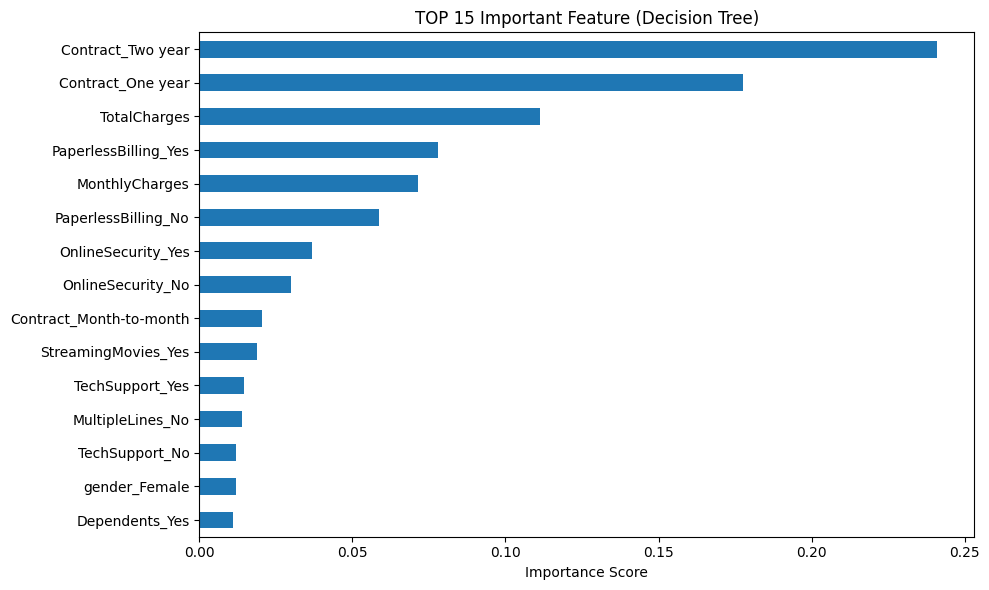

In [19]:

feature_importance = pd.Series(best_model.feature_importances_,index = x.columns)
feature_importances = feature_importance.sort_values(ascending=False)

plt.figure(figsize = (10,6))
feature_importances.head(15).plot(kind = 'barh')
plt.title('TOP 15 Important Feature (Decision Tree)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


To better understand which customer features had the most influence on churn prediction, we visualized the top 15 most important features based on the trained Decision Tree model.

From the graph, we can observe:

Contract-related features (Contract_Two year, Contract_One year) are the most influential. This suggests customers with long-term contracts are far less likely to churn.

Financial features like TotalCharges and paperlessbilling also play a significant role, indicating that billing-related aspects may affect churn behavior.

Service features such as monthlycharges, OnlineSecurity, and TechSupport contribute meaningfully — customers without these services seem more likely to churn.

Gender and dependents appear to have relatively low influence compared to other factors.

This analysis confirms that contractual commitment and billing experience are key drivers of churn behavior

FINAL CONCLUSION

- Before applying SMOTE and tuning, the baseline Decision Tree achieved a cross-validated ROC AUC of 0.66 on the imbalanced dataset.  
- The Decision Tree Classifier performed well, especially after applying SMOTE to handle class imbalance and using GridSearchCV for hyperparameter tuning. With a validation ROC AUC of 0.90 and decent recall for churners, this model provides strong interpretability along with solid performance. It also offers valuable business insights into which features most influence churn guiding targeted retention strategies.